# Causal Discovery from Time-Series Data, in the Presence of Latent Confounders

We learn a causal graph from observed time-series data, in the possible presence of latent confounders.
We assume a discrete-time, stationary structural vector autoregressive process, with both temporal and contemporaneous causal relations.
Furthermore, we assume the true underlying causal graph is a repeating directed acyclic graph (DAG), $\mathcal{D}(\mathbf{O}, \mathbf{L})$, where $\mathbf{O}$ and $\mathbf{L}$ are observed variables and latent confounders, respectively, measured during $\tau$ consecutive time steps. For this DAG, we also assume causal Markov and faithfulness assumptions.
In this setting, a maximal ancestral graph (MAG) defined over $\mathbf{O}$ is used to represent the DAG.

The TS-ICD algorithm learns a dynamic-PAG (a partial ancestral graph),
which is an equivalence class of the true causal graph.

The following steps demonstrate how to use the TS-ICD algorithm for learning from time-series data.
1. Experiment setup using real-world data
3. Causal graph learning using the TS-ICD algorithm
4. Visualization of the result



## Experiment Setup

First, import required classes and methods.

In [7]:
import numpy as np
from causal_discovery_algs.ts_icd import LearnStructTSICD  # TS-ICD algorithm
from causal_discovery_utils.data_utils import unroll_temporal_data  # temporal data pre-processing
from causal_discovery_utils.cond_indep_tests import CondIndepParCorr  # conditional independence test
from plot_utils import draw_temporal_graph  # visualization

Next, load real-world data and set experiment parameters.
The data is average daily water levels of rivers in the upper Danube basin. Data source: Bavarian State Office for the Environment, https://www.lfu.bayern.de (download from https://www.gkd.bayern.de/en).
For this experiments, we follow Gerhardus and Runge (2020) and use measurements in three sites: Iller at Kempten, Danube at Dillingen, and Isar at Lenggries.

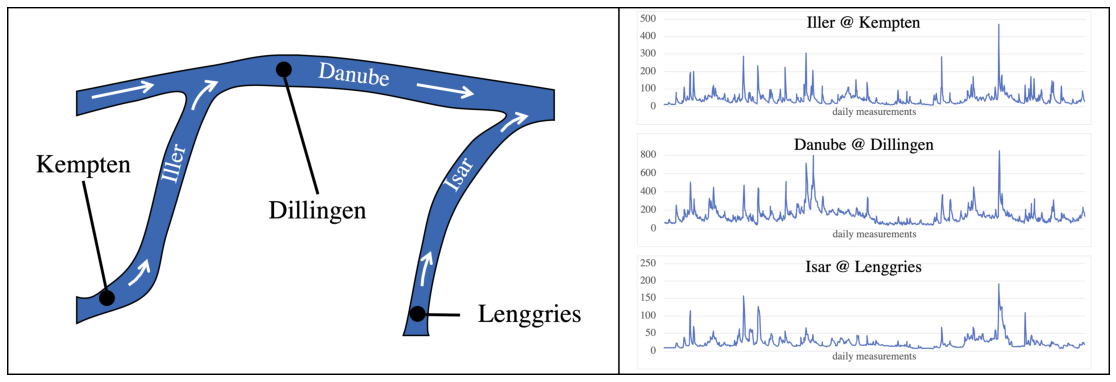

In [8]:
from matplotlib import pyplot as plt
import matplotlib
river_sketch = plt.imread('imgs/TimeSeriesMeasurmentSites.png')
dpi = matplotlib.rcParams['figure.dpi']
plt.figure(figsize=(river_sketch.shape[0] / dpi, river_sketch.shape[1] / dpi))
sketch_fig = plt.imshow(river_sketch)
sketch_fig.axes.set_axis_off()

Analysis of this real-world data and the plausibility of causal relations is discussed by Gerhardus and Runge (2020). In essence, note that Iller discharges into the Danube upstream of Dillingen, whereas Isar discharges into the Danube downstream of Dillingen. Moreover, water from Kempten reaches Dillingen withing a day, and therefore a contemporaneous causal relation is expected. No relations are expected between measurements at Lenggries and measurements at the other two stations, except for ones resulting from weather conditions, such as rainfall.

In [9]:
# learning parameters
alpha = 0.001
window_len = 3

# load data.  Data source: Bavarian State Office for the Environment, www.lfu.bayern.de. Download from https://www.gkd.bayern.de/en
folder_name = '../example_data/average_river_levels/'
measurement_stations = ['Dillingen', 'Kempten', 'Lenggries']  # names of measurement stations

stations_data = []
for station_name in measurement_stations:
    data = np.loadtxt(folder_name + station_name + '.csv', delimiter=',', dtype=float)
    stations_data.append(data)

measurements_data = np.stack(stations_data, axis=1)
n_stations = measurements_data.shape[1]  # number of measurement stations
n_time_steps = measurements_data.shape[0]  # number of data samples (measurement days)

Data is a numpy $n\times3$ array, where each column corresponds to a measurment station, and $n$ is the number of data samples.


Next, unroll the data with respect to the time-window (`window_len`).


In [10]:
observed_vars = list(range(n_stations))  # indexes of observed variables
data_full_unrolled, _nodes_sets_list_full, _nodes_sets_list = unroll_temporal_data(measurements_data,
                                                                                   observed_nodes_list=observed_vars,
                                                                                   window_len=window_len,
                                                                                   reverse_temporal_order=True)

The unrolled data is a numpy $n\times 9$ array, where the first three columns represent present-time, $t$, measurements, the next tree columns represent measurements at $t-1$, and the last tree columns represent measurements at $t-2$. This reverse temporal order, which is required by TS-ICD, is set using the parameter `reverse_temporal_order=True`.

## Causal graph learning using the TS-ICD algorithm

First, set a CI-test based on partial correlation, then initialize the TS-ICD learner, and finally, learn the causal graph (an equivalence class in the form of a dynamic-PAG).

In [11]:
ci_test = CondIndepParCorr(dataset=data_full_unrolled, threshold=alpha, count_tests=True, use_cache=True)  # CI test
ts_icd = LearnStructTSICD(nodes_sets_list=_nodes_sets_list, ci_test=ci_test)  # initialize TS-ICD learner
ts_icd.learn_structure()  # learn the causal graph


## Result visualization

A plot of the causal graph includes a single instance of each homology. Present-time nodes ($t$) are called endogenous nodes, and past nodes ($[t-2,t-1]$) are called exogenous nodes. Edges among endogenous nodes represent contemporaneous relations, and edges between exogenous and endogenous nodes represent temporal relations. Endogenous nodes are enclosed by a rectangle.

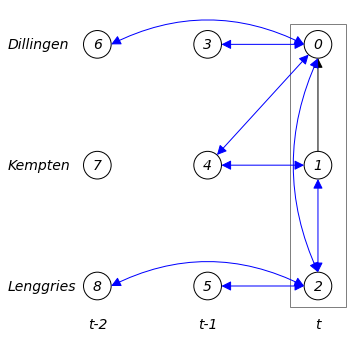

In [12]:
columns_labels = ['t-{}'.format(t) for t in range(1, window_len)]  # set column labels
columns_labels = ['t'] + columns_labels
fig = draw_temporal_graph(ts_icd.graph, _nodes_sets_list, column_labels=columns_labels,
                          row_labels=measurement_stations)  # draw graph

A contemporaneous causal relation from Kempten to Dillingen, $node(1) \rightarrow node(0)$ is correctly identified. This is expected as water from Kempten reaches Dillingen within a day. No causal relations are found between measurements at Lenggries and measurements at the other two stations, except for ones described by hidden confounders (bi-directed edges). The detected hidden confounders may represent weather conditions, such as rainfall.

A contemporaneous causal relation from Kempten to Dillingen, $node(1) \rightarrow node(0)$ is correctly identified. This is expected as water from Kempten reaches Dillingen within a day. No causal relations are found between measurements at Lenggries and measurements at the other two stations, except for ones described by hidden confounders (bi-directed edges). The detected hidden confounders may represent weather conditions, such as rainfall.

## References

Andreas Gerhardus and Jakob Runge. High-recall causal discovery for autocorrelated time series with latent confounders. Advances in Neural Information Processing Systems, 33:12615–12625, 2020.